<div id="Import Libraries">

# **Importing Libraries** 

In [30]:
import os
import gc
import cv2
import json
import time
import shutil
import numpy as np
from tqdm import tqdm
import mediapipe as mp
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from concurrent.futures import ThreadPoolExecutor
from IPython.display import clear_output, FileLink
import keras
from PIL import Image, ImageOps
from keras import layers

In [37]:
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [214]:
DATA_DIR = "../data/asl_words_video/"
VIDEOS_DIR = "../data/asl_words_video/videos/"
PROCESSED_DIR = "../data/asl_words_video/processed/"
PROCESSED_VIDEOS_DIR = "../data/asl_words_video/processed/videos/"
MODEL_DIR = "../models/"

In [4]:
os.makedirs(PROCESSED_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

---

<div id="Label Filtering">

# **Label Filtering**
**<h2>(Done Once)**

In [170]:
import fasttext
import fasttext.util

fasttext.util.download_model('en', if_exists='ignore')
ft = fasttext.load_model("./cc.en.300.bin")

In [171]:
with open(DATA_DIR + "/WLASL_v0.3.json", "r") as json_file:
    orig_data = json.load(json_file)

In [172]:
list_labels = list()
for i in range(len(orig_data)):
    gloss = orig_data[i]["gloss"]
    list_labels.append(gloss)
labels = list(np.unique(list_labels))

In [173]:
encoded_labels = {label: ft.get_word_vector(label) for label in labels}

In [174]:
def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

In [203]:
chosen_words = [
    "hello",
    "goodbye",
    "thank you",
    "sorry",
    "yes",
    "no",
    "help",
]

In [206]:
WORDS_SIMILARITY_THRESHOLD = 0.8
similar_words_set = set()
popular_word_vectors = [ft.get_word_vector(word) for word in chosen_words]

for label, label_vector in encoded_labels.items():
    for popular_word_vector in popular_word_vectors:
        similarity_score = cosine_similarity(popular_word_vector, label_vector)
        if similarity_score > WORDS_SIMILARITY_THRESHOLD:
            similar_words_set.add(label)

similar_words_list = list(similar_words_set)

In [90]:
encoded_filtered_labels = {
    label: ft.get_word_vector(label) for label in similar_words_list
}
np.savez_compressed(PROCESSED_DIR + "filtered_labels.npz", **encoded_filtered_labels)

In [207]:
with open(PROCESSED_DIR + "filtered_labels.txt", "w+") as file:
    for label in similar_words_list:
        file.write(label + "\n")

---

<div id="Data_Preparation">
    
# **Data Preparation**
**<h2>(Done Once)**

In [5]:
with open(DATA_DIR + "/WLASL_v0.3.json", "r") as json_file:
    all_data = json.load(json_file)

In [6]:
labels = []
with open(PROCESSED_DIR + "filtered_labels.txt", "r") as file:
    labels = file.read().splitlines()

In [ ]:
data = []  # formatted data

for i in tqdm(range(len(all_data)), ncols=100):
    # for i in tqdm(range(10), ncols=100):
    gloss = all_data[i]["gloss"]

    if gloss not in labels:
        continue

    instances = all_data[i]["instances"]
    for instance in instances:
        video_id = instance["video_id"]
        if os.path.exists(os.path.join(VIDEOS_DIR, f"{video_id}.mp4")) == False:
            continue

        frame_start = instance["frame_start"]
        frame_end = instance["frame_end"]
        split = instance["split"]
        data.append(
            {
                "gloss": gloss,
                "video_id": video_id,
                "frame_start": frame_start,
                "frame_end": frame_end,
                "split": split,
            }
        )

In [211]:
with open(PROCESSED_DIR + "/WLASL_parsed_data.json", "w+") as json_file:
    json.dump(data, json_file, indent=4)

---

<div id="Videos_Standardization">

# **Videos Standardization**

In [7]:
IMAGE_SIZE = 224
PADDING_COLOUR = [0, 255, 0]
CROP_MARGIN = 50

In [8]:
def resize_image(image, height=IMAGE_SIZE, width=IMAGE_SIZE):
    image = Image.fromarray(image)
    image.thumbnail((width, height))
    image = np.asarray(image)
    y_border = max(height - image.shape[0], 0)
    x_border = max(width - image.shape[1], 0)
    top = y_border
    bottom = 0
    left = x_border
    right = 0
    image = cv2.copyMakeBorder(
        image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=PADDING_COLOUR
    )
    return image

In [9]:
hands = mp.solutions.hands.Hands()


def get_2hands_coord(image_rgb):
    result = hands.process(image_rgb)
    height, width, _ = image_rgb.shape
    # Check if hands are detected

    left_x = width
    right_x = 0
    bottom_y = height
    top_y = 0

    if result.multi_hand_landmarks:
        x_coordinates = []
        y_coordinates = []
        for hand_landmarks in result.multi_hand_landmarks:
            # Draw landmarks on the frame
            # mp.solutions.drawing_utils.draw_landmarks(image_rgb, hand_landmarks, mp.solutions.hands.HAND_CONNECTIONS)

            # Get the top left corner of the detected hand's bounding box.
            # x_coordinates = []
            # y_coordinates = []
            for landmark in hand_landmarks.landmark:
                x_coordinates.append(landmark.x)
                y_coordinates.append(landmark.y)

        left_x = int(min(x_coordinates) * width)
        right_x = int(max(x_coordinates) * width)
        bottom_y = int(min(y_coordinates) * height)
        top_y = int(max(y_coordinates) * height)

    return (left_x, right_x, top_y, bottom_y)

I0000 00:00:1728553034.067372 8664432 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M3 Pro


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1728553034.078972 8705478 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1728553034.082915 8705484 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [10]:
def check_start_end_frames(video_cap, start_frame=1, end_frame=-1):
    # if the starting is 0
    if start_frame <= 1:
        start_frame = 1

    # if the video is precropped
    elif start_frame > int(video_cap.get(cv2.CAP_PROP_FRAME_COUNT)):
        start_frame = 1
        end_frame = int(video_cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # if the final frame was not given (-1)
    if end_frame < 0:
        end_frame = int(video_cap.get(cv2.CAP_PROP_FRAME_COUNT))

    return (start_frame, end_frame)

In [11]:
def get_video_hands_coord(video_path, start_frame=1, end_frame=-1):
    cap = cv2.VideoCapture(video_path)

    (start_frame, end_frame) = check_start_end_frames(cap, start_frame, end_frame)

    # num_landmarks = HAND_NUM * 2 + POSE_NUM + FACE_NUM
    # all_frame_landmarks = np.zeros((end_frame - start_frame + 1, num_landmarks, 3))
    frame_index = 1
    list_left_x = []
    list_right_x = []
    list_top_y = []
    list_bottom_y = []

    while cap.isOpened() and frame_index <= end_frame:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_index >= start_frame:
            frame.flags.writeable = False
            # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            (left_x, right_x, top_y, bottom_y) = get_2hands_coord(frame)

            list_left_x.append(left_x)
            list_right_x.append(right_x)
            list_top_y.append(top_y)
            list_bottom_y.append(bottom_y)

        frame_index += 1

    cap.release()
    hands.reset()

    return (min(list_left_x), max(list_right_x), max(list_top_y), min(list_bottom_y))

In [12]:
def crop_image(image, left_x, right_x, top_y, bottom_y):
    orig_height, orig_width, _ = image.shape

    if left_x > right_x:
        tmp = left_x
        left_x = right_x
        right_x = tmp
    if bottom_y > top_y:
        tmp = top_y
        top_y = bottom_y
        bottom_y = tmp

    left_x = max(left_x - CROP_MARGIN, 0)
    right_x = min(right_x + CROP_MARGIN, orig_width)
    bottom_y = max(bottom_y - CROP_MARGIN, 0)
    top_y = min(top_y + CROP_MARGIN, orig_height)

    cropped_image = image[bottom_y:top_y, left_x:right_x]

    cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_RGB2BGR)

    return cropped_image

In [13]:
def load_video(video_path, start_frame=1, end_frame=-1):
    cap = cv2.VideoCapture(video_path)
    frames = []

    (start_frame, end_frame) = check_start_end_frames(cap, start_frame, end_frame)

    (left_x, right_x, top_y, bottom_y) = get_video_hands_coord(
        video_path, start_frame, end_frame
    )

    frame_index = 1
    while cap.isOpened() and frame_index <= end_frame:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_index >= start_frame:
            # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = crop_image(frame, left_x, right_x, top_y, bottom_y)
            frame = resize_image(frame)

            # frame = frame[:, :, [2, 1, 0]]

            frames.append(frame)

            frame_index += 1
    cap.release()

    return np.array(frames)

---

<div id="Features_Extraction">

# **Features Extraction**

In [14]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMAGE_SIZE, IMAGE_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

---

<div id="Data_Loading">
    
# **Data Loading**

In [217]:
MAX_SEQ_LENGTH = 30
NUM_FEATURES = 2048

In [16]:
with open(PROCESSED_DIR + "WLASL_parsed_data.json", "r") as json_file:
    data = json.load(json_file)

In [17]:
labels_dict = np.load(PROCESSED_DIR + "filtered_labels.npz", allow_pickle=True)

In [18]:
def prepare_all_videos(data, split):
    split_data = [i for i in data if i["split"] == split]

    num_samples = len(split_data)

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denotin g if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )
    video_labels = []

    for idx in range(num_samples):
        video_label = split_data[idx]["gloss"]

        video_labels.append(video_label)

        video_id = split_data[idx]["video_id"]
        video_path = os.path.join(VIDEOS_DIR, f"{video_id}.mp4")
        start = split_data[idx]["frame_start"]
        end = split_data[idx]["frame_end"]

        frames = load_video(video_path, start_frame=start, end_frame=end)
        if len(frames) > MAX_SEQ_LENGTH:
            cropped_frames = len(frames) - MAX_SEQ_LENGTH
            frames = frames[
                (cropped_frames // 2) : (cropped_frames // 2 + MAX_SEQ_LENGTH)
            ]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(
            shape=(
                1,
                MAX_SEQ_LENGTH,
            ),
            dtype="bool",
        )
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        length = len(frames)
        for i, frame in enumerate(frames):
            temp_frame_features[0, i, :] = feature_extractor.predict(
                frame[None, ...],
                verbose=0,
            )
        temp_frame_mask[0, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()
        # break

    return (frame_features, frame_masks), video_labels

In [19]:
def prepare_all_videos_for_transformer(data, split):
    split_data = [i for i in data if i["split"] == split]

    num_samples = len(split_data)

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )
    video_labels = []

    for idx in range(num_samples):
        video_label = split_data[idx]["gloss"]

        video_labels.append(video_label)

        video_id = split_data[idx]["video_id"]
        video_path = os.path.join(VIDEOS_DIR, f"{video_id}.mp4")
        start = split_data[idx]["frame_start"]
        end = split_data[idx]["frame_end"]

        frames = load_video(video_path, start_frame=start, end_frame=end)
        if len(frames) == 0:
            continue

        if len(frames) > MAX_SEQ_LENGTH:
            cropped_frames = len(frames) - MAX_SEQ_LENGTH
            frames = frames[
                (cropped_frames // 2) : (cropped_frames // 2 + MAX_SEQ_LENGTH)
            ]
        # Pad shorter videos.
        elif len(frames) < MAX_SEQ_LENGTH:
            diff = MAX_SEQ_LENGTH - len(frames)
            padding = np.zeros((diff, IMAGE_SIZE, IMAGE_SIZE, 3))
            frames = np.concatenate((frames, padding))
        

        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                if np.mean(batch[j, :]) > 0.0:
                    temp_frame_features[i, j, :] = feature_extractor.predict(
                        batch[None, j, :]
                    )

                else:
                    temp_frame_features[i, j, :] = 0.0

        frame_features[idx,] = temp_frame_features.squeeze()
        # break

    return frame_features, video_labels

In [218]:
X_train, y_train = prepare_all_videos(data, "train")

print(f"Frame features in train set: {X_train[0].shape}")
print(f"Frame masks in train set: {X_train[1].shape}")

# X_train, y_train = prepare_all_videos_for_transformer(data, "train")

W0000 00:00:1728602658.793670 8705483 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1728602658.801905 8705480 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1728602662.483999 8705485 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1728602662.487964 8705485 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1728602665.435326 8705486 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1728602665.439947 8705486 inference_feedback_manager.cc:114] Feedback manager 

Frame features in train set: (40, 30, 2048)
Frame masks in train set: (40, 30)


In [220]:
X_val, y_val = prepare_all_videos(data, "val")

print(f"Frame features in val set: {X_val[0].shape}")
print(f"Frame masks in val set: {X_val[1].shape}")

# X_val, y_val = prepare_all_videos_for_transformer(data, "val")

W0000 00:00:1728602917.483232 8705478 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1728602917.486910 8705478 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1728602920.468870 8705482 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1728602920.471867 8705485 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1728602923.739783 8705487 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1728602923.744703 8705487 inference_feedback_manager.cc:114] Feedback manager 

Frame features in val set: (10, 30, 2048)
Frame masks in val set: (10, 30)


In [221]:
X_test, y_test = prepare_all_videos(data, "test")

print(f"Frame features in test set: {X_test[0].shape}")
print(f"Frame masks in test set: {X_test[1].shape}")

# X_test, y_test = prepare_all_videos_for_transformer(data, "test")

W0000 00:00:1728602977.124702 8705487 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1728602977.136896 8705487 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1728602980.586784 8705482 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1728602980.590486 8705485 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1728602983.472179 8705485 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1728602983.474707 8705485 inference_feedback_manager.cc:114] Feedback manager 

Frame features in test set: (10, 30, 2048)
Frame masks in test set: (10, 30)


In [23]:
# print(f"Frame features in train set: {X_train.shape}")
# print(f"Frame features in val set: {X_val.shape}")
# print(f"Frame features in test set: {X_test.shape}")

Frame features in train set: (40, 50, 2048)
Frame features in val set: (10, 50, 2048)
Frame features in test set: (10, 50, 2048)


In [177]:
y_val

['help',
 'help',
 'no',
 'no',
 'yes',
 'yes',
 'sorry',
 'thank you',
 'hello',
 'goodbye']

---

<div id="Label_Encoding">
    
# **Label Encoding**

In [25]:
labels = []
with open(PROCESSED_DIR + "filtered_labels.txt", "r") as file:
    labels = file.read().splitlines()

In [26]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(labels)
)
print(label_processor.get_vocabulary())

['goodbye', 'hello', 'help', 'no', 'sorry', 'thank you', 'yes']


In [178]:
y_train_2 = keras.ops.convert_to_numpy(label_processor(list(y_train)))
y_val_2 = keras.ops.convert_to_numpy(label_processor(list(y_val)))
y_test_2 = keras.ops.convert_to_numpy(label_processor(list(y_test)))


In [179]:
y_train_2.shape

(40,)

In [163]:
y_train_1 = np.array([labels_dict[label] for label in y_train])
y_val_1 = np.array([labels_dict[label] for label in y_val])
y_test_1 = np.array([labels_dict[label] for label in y_test])

---

<div id="Model_Building">
    
# **Model Building**

In [206]:
# Utility for our sequence model.
def get_sequence_model_1():

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.GRU(512, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(512)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(512, activation="relu")(x)
    output = keras.layers.Dense(300, activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    adam = tf.keras.optimizers.Adam(
        learning_rate=0.0001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-06,
        amsgrad=False,
        name="Adam",
    )

    rnn_model.compile(
        loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"]
    )
    return rnn_model

In [247]:
def get_sequence_model_2():

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.GRU(400, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(200)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(100, activation="relu")(x)
    output = keras.layers.Dense(len(label_processor.get_vocabulary()), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    adam = tf.keras.optimizers.Adam(
        learning_rate=2.5e-6,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-06,
        amsgrad=False,
        name="Adam",
    )

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer=adam, metrics=["accuracy"]
    )
    return rnn_model

In [233]:
def get_sequence_model_3():

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.GRU(500, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(200, return_sequences=True)(x)
    x = keras.layers.GRU(200)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(200, activation="relu")(x)
    x = keras.layers.Dense(100, activation="relu")(x)
    x = keras.layers.Dense(50, activation="relu")(x)
    output = keras.layers.Dense(len(label_processor.get_vocabulary()), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    adam = tf.keras.optimizers.Adam(
        learning_rate=0.000002,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-06,
        amsgrad=False,
        name="Adam",
    )

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer=adam, metrics=["accuracy"]
    )
    return rnn_model

In [236]:
EPOCHS = 200

In [230]:
# Utility for running experiments.
def run_experiment(model, train_data, train_label, val_data, val_label, test_data, test_label, model_save_name):
    filepath = MODEL_DIR + model_save_name
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    history = model.fit(
        [train_data[0], train_data[1]],
        train_label,
        validation_data=([val_data[0], val_data[1]], val_label),
        epochs=EPOCHS,
        callbacks=[
            checkpoint,
            # keras.callbacks.EarlyStopping(
            #     monitor="val_loss", patience=10, restore_best_weights=True
            # ),
        ],
    )

    model.load_weights(filepath)
    _, accuracy = model.evaluate([test_data[0], test_data[1]], test_label)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history

In [250]:
model = get_sequence_model_2()

In [251]:
hist = run_experiment(
    model,
    X_train,
    y_train_2,
    X_val,
    y_val_2,
    X_test,
    y_test_2,
    MODEL_DIR + "asl_words_gru2_241011_1040.weights.h5",
)

Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.0844 - loss: 2.1602
Epoch 1: val_loss improved from inf to 2.12072, saving model to ../models/../models/asl_words_gru2_241011_1040.weights.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 318ms/step - accuracy: 0.0813 - loss: 2.1648 - val_accuracy: 0.1000 - val_loss: 2.1207
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.0812 - loss: 2.1500
Epoch 2: val_loss improved from 2.12072 to 2.11131, saving model to ../models/../models/asl_words_gru2_241011_1040.weights.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.0875 - loss: 2.1522 - val_accuracy: 0.1000 - val_loss: 2.1113
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.0844 - loss: 2.2161 
Epoch 3: val_loss improved from 2.11131 to 2.10223, saving model to ../models/../models/asl_words_gru2_241011_1040.weights.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.0813 - loss: 2.2224 - val_accuracy: 0.1000 - val_loss: 2.1022
Epoch 4/200
2/2 ━━━━━━━━━━━━

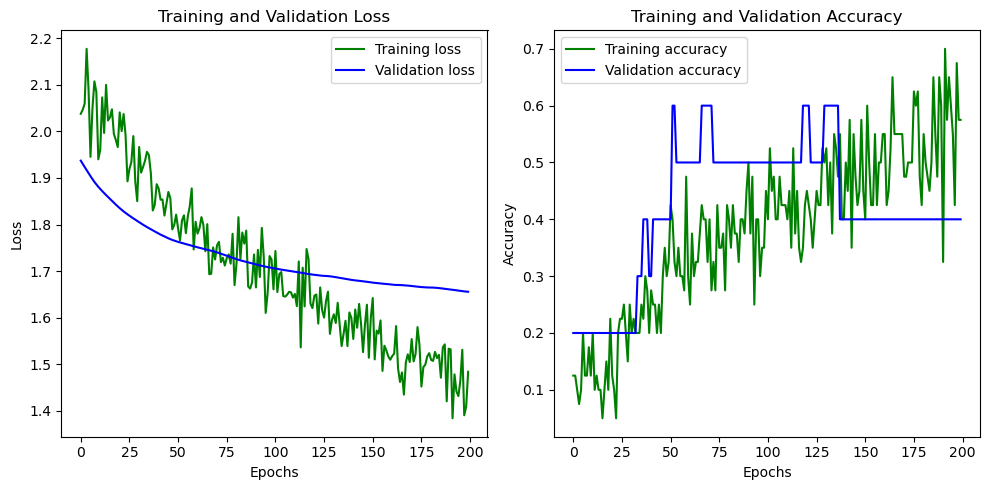

In [239]:
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

# Plotting loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, 'g', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, 'g', label='Training accuracy')
plt.plot(val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [240]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


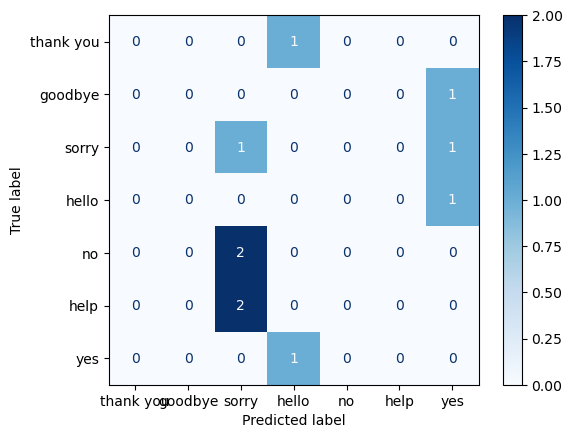

In [241]:
confusion_matrix = metrics.confusion_matrix(y_test_2, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

In [215]:
model.export(MODEL_DIR + 'asl_words_classifier/')

INFO:tensorflow:Assets written to: ../models/asl_words_classifier/assets


INFO:tensorflow:Assets written to: ../models/asl_words_classifier/assets


Saved artifact at '../models/asl_words_classifier/'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 50, 2048), dtype=tf.float32, name='keras_tensor_758'), TensorSpec(shape=(None, 50), dtype=tf.bool, name='keras_tensor_759')]
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  29014963216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  29049078800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  29014961488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  29014962832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  29014962640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  29014961872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  29014963024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  29014961296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  29066173456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  29066171536: TensorSpec(shap

In [216]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR + 'asl_words_classifier/') # path to the SavedModel directory
converter.experimental_enable_resource_variables = True
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # Enable TensorFlow Lite ops
    tf.lite.OpsSet.SELECT_TF_OPS     # Enable TensorFlow ops
]
tflite_model = converter.convert()


# Save the model.
with open(MODEL_DIR + 'asl_words_2_classifier_gru2_2410110246.tflite', 'wb') as f:
  f.write(tflite_model)

W0000 00:00:1728575926.367854 8664432 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1728575926.367892 8664432 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2024-10-11 02:58:46.512019: W tensorflow/compiler/mlir/lite/flatbuffer_export.cc:2996] TFLite interpreter needs to link Flex delegate in order to run the model since it contains the following Select TFop(s):
Flex ops: FlexTensorListReserve, FlexTensorListSetItem, FlexTensorListStack
Details:
	tf.TensorListReserve(tensor<2xi32>, tensor<i32>) -> (tensor<!tf_type.variant<tensor<?x200xf32>>>) : {device = ""}
	tf.TensorListReserve(tensor<2xi32>, tensor<i32>) -> (tensor<!tf_type.variant<tensor<?x400xf32>>>) : {device = ""}
	tf.TensorListSetItem(tensor<!tf_type.variant<tensor<?x200xf32>>>, tensor<i32>, tensor<?x200xf32>) -> (tensor<!tf_type.variant<tensor<?x200xf32>>>) : {device = "", resize_if_index_out_of_bounds = false}
	tf.TensorListSetItem(tensor<!tf_type.variant<tensor<?x400xf32>>>, tensor<

---

# Transformer

In [31]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim
        )
        self.sequence_length = sequence_length
        self.output_dim = output_dim

    def build(self, input_shape):
        self.position_embeddings.build(input_shape)

    def call(self, inputs):
        # The inputs are of shape: `(batch_size, frames, num_features)`
        inputs = keras.ops.cast(inputs, self.compute_dtype)
        length = keras.ops.shape(inputs)[1]
        positions = keras.ops.arange(start=0, stop=length, step=1)
        embedded_positions = self.position_embeddings(positions)
        return inputs + embedded_positions

In [79]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.3
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(dense_dim, activation=keras.activations.gelu),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

In [163]:
def get_compiled_model(shape):
    sequence_length = MAX_SEQ_LENGTH
    embed_dim = NUM_FEATURES
    dense_dim = 4
    num_heads = 1
    classes = len(label_processor.get_vocabulary())

    inputs = keras.Input(shape=shape)
    x = PositionalEmbedding(
        sequence_length, embed_dim, name="frame_position_embedding"
    )(inputs)
    x = TransformerEncoder(embed_dim, dense_dim, num_heads, name="transformer_layer")(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(50, activation="relu")(x)
    outputs = layers.Dense(classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    adam = tf.keras.optimizers.Adam(
        learning_rate=1.1e-06,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-06,
        amsgrad=False,
        name="Adam",
    )

    model.compile(
        optimizer=adam,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


In [169]:
def run_experiment(train_data, train_labels, val_data, val_labels, test_data, test_labels):
    filepath = MODEL_DIR + "video_classifier_241011_0225.weights.h5"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    model = get_compiled_model(train_data.shape[1:])
    history = model.fit(
        train_data,
        train_labels,
        validation_data=(val_data, val_labels),
        epochs=500,
        callbacks=[checkpoint],
    )

    model.load_weights(filepath)
    _, accuracy = model.evaluate(test_data, test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, model

In [170]:
history, trained_model = run_experiment(X_train, y_train_2, X_val, y_val_2, X_test, y_test_2)

Epoch 1/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.1813 - loss: 5.3740
Epoch 1: val_loss improved from inf to 4.37224, saving model to ../models/asl_words_classifier/video_classifier_241011_0225.weights.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 410ms/step - accuracy: 0.1792 - loss: 5.3994 - val_accuracy: 0.0000e+00 - val_loss: 4.3722
Epoch 2/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.1406 - loss: 5.4634
Epoch 2: val_loss improved from 4.37224 to 4.29592, saving model to ../models/asl_words_classifier/video_classifier_241011_0225.weights.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step - accuracy: 0.1354 - loss: 5.5376 - val_accuracy: 0.0000e+00 - val_loss: 4.2959
Epoch 3/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.2937 - loss: 5.3263
Epoch 3: val_loss improved from 4.29592 to 4.22177, saving model to ../models/asl_words_classifier/video_classifier_241011_0225.weights.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step - accuracy: 0.2875 - loss: 5.3737 - val_accuracy: 0.000

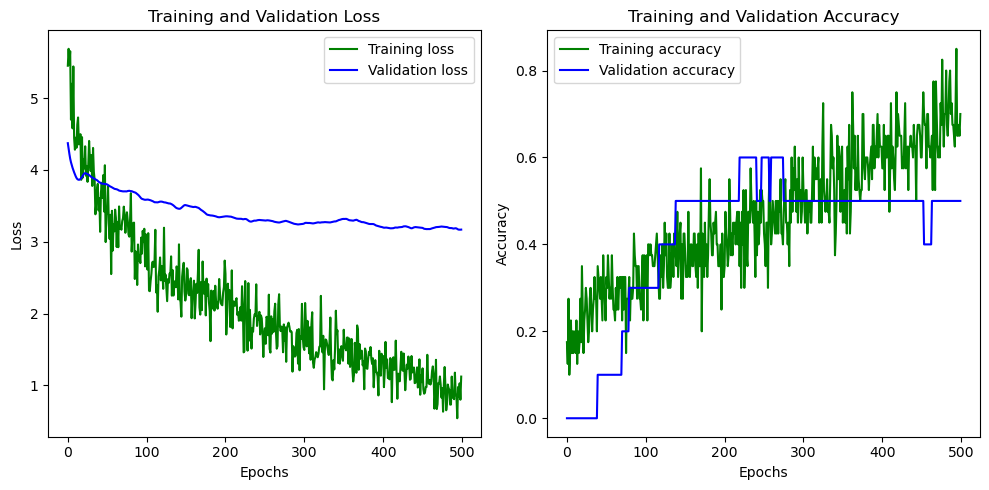

In [171]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plotting loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, 'g', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, 'g', label='Training accuracy')
plt.plot(val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


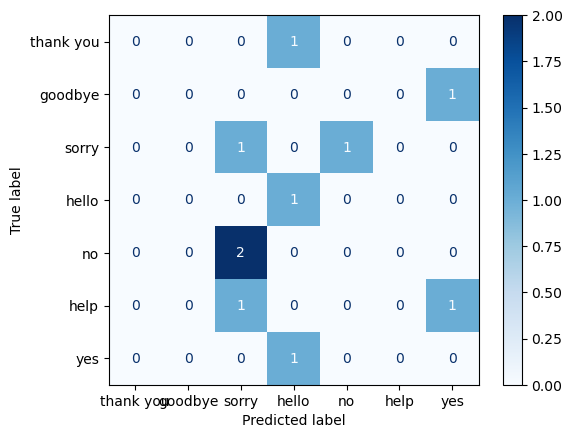

In [172]:
y_pred = trained_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

confusion_matrix = metrics.confusion_matrix(y_test_2, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()